In [71]:
# !pip install -q tensorflow-gpu==2.0.0-beta0

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from torch_two_sample.statistics_diff import MMDStatistic
import torch

import matplotlib.pyplot as plt
import numpy as np
import random

from IPython import display
from tqdm import tqdm
from shutil import copyfile


print(tf.__version__)


# from google.colab import drive
# drive.mount('/drive')


norm_value = 2173


#################################################################################
#          Helper functions
#################################################################################
def test_show(generator, discriminator):
    noise = tf.random.normal([1, 125, 50])
    generated_ecg = generator(noise, training=False)
    print(generated_ecg.shape)
    plt.plot(generated_ecg[0, 0, :])
    plt.show()
    
    decision = discriminator(generated_ecg, training=False)
    print(decision)
    

def generate_and_save_ecg(model, epoch, test_input, save):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,3))
    plt.plot(predictions[0, 0, :] * norm_value)
    # plt.plot(predictions[0, 0, :])
    
    if save:
        plt.savefig('./ecg_at_epoch_{:04d}.png'.format(epoch))

    plt.show()
    

def prepare_data(dim):
#     copyfile(f"/drive/My Drive/Colab Notebooks/data/fix_signals_400.npy", "./fix_signals.npy")

    data = np.load('./data/fix_signals_400.npy')
    data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
    print('Data shape:', data.shape)

    data = data / norm_value # Normalize
    data = np.array(data, dtype='float32')

    plt.figure(figsize=(4,3))
    plt.plot(data[random.randint(0, data.shape[0])][0] * norm_value)
    plt.show()

    train_size = int(data.shape[0] * 0.9)
    test_size = data.shape[0] - train_size
    print(train_size, test_size)

    # Batch and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices(data[:train_size]).shuffle(train_size).batch(BATCH_SIZE)
    test_dataset  = tf.data.Dataset.from_tensor_slices(data[train_size:]).shuffle(test_size).batch(1)

    seed = tf.random.normal(dim)
    
    return seed, train_dataset, test_dataset

2.2.0


In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(100, 12)))

    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
  
    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1D(filters=16, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=1, kernel_size=16, strides=1, padding='same', activation='tanh'))
    
    model.add(layers.Permute((2, 1)))
    
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
   
    model.add(layers.Input(shape=(1, 400)))
    model.add(layers.Permute((2, 1)))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=256, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator     = make_generator_model()
discriminator = make_discriminator_model()
    
generator.summary()
discriminator.summary()

# test_show(generator, discriminator)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 100, 128)          39424     
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 100, 128)          262272    
_________________________________________________________________
leaky_re_lu_138 (LeakyReLU)  (None, 100, 128)          0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 100, 64)           131136    
_________________________________________________________________
leaky_re_lu_139 (LeakyReLU)  (None, 100, 64)           0         
_________________________________________________________________
up_sampling1d_35 (UpSampling (None, 200, 64)           0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 200, 32)         

In [0]:
#################################################################################
#          Prepare metrics for logging
#################################################################################

# !rm -rf ./logs/

### discriminator loss ###
# disc_log_dir = 'logs/gradient_tape/disc_loss'
# disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
disc_losses_list = []

### discriminator accuracy ###
fake_disc_accuracy = tf.keras.metrics.BinaryAccuracy('fake_disc_accuracy')
real_disc_accuracy = tf.keras.metrics.BinaryAccuracy('real_disc_accuracy')
fake_disc_accuracy_list, real_disc_accuracy_list = [], []

### generator loss ###
# gen_log_dir = 'logs/gradient_tape/gen_loss'
# gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
gen_losses_list = []


#################################################################################
#          Prepare loss functions and optimizers
#################################################################################

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [0]:
disc_steps = 1

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_ecg, dim):
    noise = tf.random.normal(dim)

    for i in range(disc_steps):
        with tf.GradientTape() as disc_tape:
            generated_ecg = generator(noise, training=True)

            real_output = discriminator(real_ecg, training=True)
            fake_output = discriminator(generated_ecg, training=True)

            disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        ### for tensorboard ###
        disc_losses.update_state(disc_loss)
        fake_disc_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
        real_disc_accuracy.update_state(tf.ones_like(real_output), real_output)
        #######################
    
    with tf.GradientTape() as gen_tape:
        generated_ecg = generator(noise, training=True)
        fake_output = discriminator(generated_ecg, training=True)

        gen_loss = generator_loss(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    ### for tensorboard ###
    gen_losses.update_state(gen_loss)
    #######################
    

def train(dataset, epochs, dim):
    for epoch in tqdm(range(epochs)):
    
        for batch in dataset:
            train_step(batch, dim)
            
        disc_losses_list.append(disc_losses.result().numpy())
        gen_losses_list.append(gen_losses.result().numpy())
        
        fake_disc_accuracy_list.append(fake_disc_accuracy.result().numpy())
        real_disc_accuracy_list.append(real_disc_accuracy.result().numpy())
        
        ### for tensorboard ###
#         with disc_summary_writer.as_default():
#             tf.summary.scalar('loss', disc_losses.result(), step=epoch)
#             tf.summary.scalar('fake_accuracy', fake_disc_accuracy.result(), step=epoch)
#             tf.summary.scalar('real_accuracy', real_disc_accuracy.result(), step=epoch)
            
#         with gen_summary_writer.as_default():
#             tf.summary.scalar('loss', gen_losses.result(), step=epoch)
            
        disc_losses.reset_states()        
        gen_losses.reset_states()
        
        fake_disc_accuracy.reset_states()
        real_disc_accuracy.reset_states()
        #######################

        # Save the model every 5 epochs
#         if (epoch + 1) % 5 == 0:
#             generate_and_save_ecg(generator, epochs, seed, False)
#             checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_ecg(generator, epochs, seed, False)
    
#     generator.save('/content/drive/My Drive/Colab Notebooks/saved_models/generator_1500.h5')
#     discriminator.save('/content/drive/My Drive/Colab Notebooks/saved_models/discriminator_1500.h5')

Data shape: (7621, 1, 400)


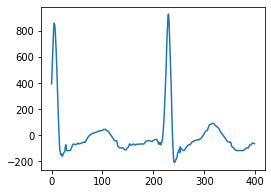

6858 763


In [3]:
BATCH_SIZE = 64
noise_dim = [BATCH_SIZE, 100, 12]

seed, train_dataset, test_dataset = prepare_data(noise_dim)

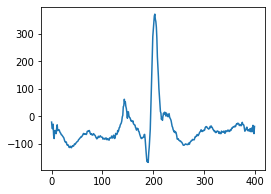

In [0]:
train(train_dataset, 5, noise_dim)

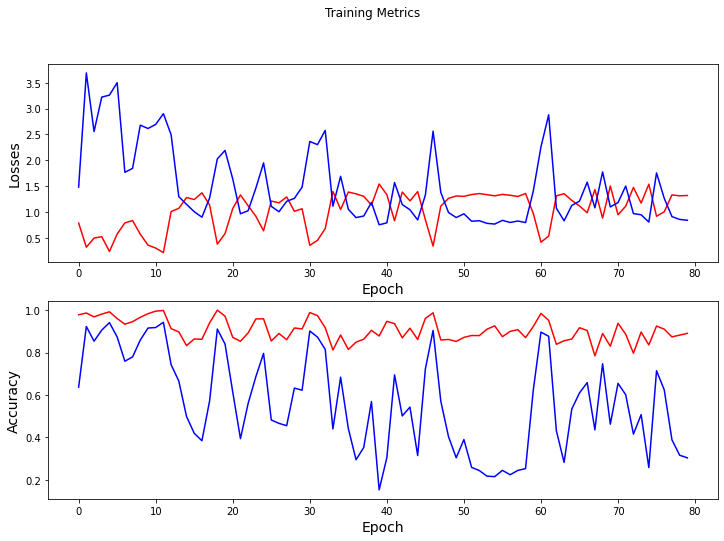

In [0]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/gradient_tape

fig, axes = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Losses", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].plot(disc_losses_list, color='red')
axes[0].plot(gen_losses_list, color='blue')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(fake_disc_accuracy_list, color='red')
axes[1].plot(real_disc_accuracy_list, color='blue')
plt.show()

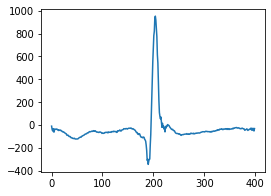

tf.Tensor([0.7015703], shape=(1,), dtype=float32)


In [0]:
seed = tf.random.normal(noise_dim)
ecg = generator(seed, training=False)
answer = discriminator(ecg)
fig = plt.figure(figsize=(4,3))
plt.plot(ecg[0, 0, :] * norm_value)
plt.show()
print(answer[0])

In [0]:
generator.save('/drive/My Drive/Colab Notebooks/saved_models/generator_80e.h5')
discriminator.save('/drive/My Drive/Colab Notebooks/saved_models/discriminator_80e.h5')

In [11]:
model = tf.keras.models.load_model('generator_80e.h5')

In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 100, 128)          39424     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 100, 128)          262272    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 100, 128)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 100, 64)           131136    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 100, 64)           0         
_________________________________________________________________
up_sampling1d_10 (UpSampling (None, 200, 64)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 200, 32)         

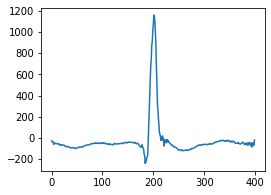

In [90]:
seed = tf.random.normal([1, 100, 12])
ecg = model(seed, training=False)
fig = plt.figure(figsize=(4,3))
plt.plot(ecg[0, 0, :] * norm_value)
plt.show()

In [82]:
#################################################################################
#          Testing functions
#################################################################################
def rmse(targets, predictions):
    return np.sqrt(np.mean((targets-predictions)**2))


def prd(targets, predictions):
    s1 = np.sum((targets-predictions)**2)
    s2 = np.sum(targets**2)
    return np.sqrt(s1 / s2 * 100)


def mmd(targets, predictions):
    mmd_stat = MMDStatistic(400, 400)
    sample_target = torch.from_numpy(targets.numpy().reshape((400,1)))
    sample_pred = torch.from_numpy(predictions.numpy().reshape((400,1)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.])
    return(stat.item())


def testing(test_dataset, model, noise_dim):
    noise = tf.random.normal(noise_dim)
    generated_ecgs = model(noise, training=False)

    mmd_sum, prd_sum, rmse_sum = [], [], []
    for true_ecg, gen_ecg in zip(test_dataset, generated_ecgs):
        prd_sum.append(prd(true_ecg[0][0], gen_ecg[0]))
        rmse_sum.append(rmse(true_ecg[0][0], gen_ecg[0]))
        mmd_sum.append(mmd(true_ecg[0][0], gen_ecg[0]))

    print('mmd :', f'mean={np.mean(mmd_sum):.6f}', f'min={np.min(mmd_sum):.6f}', f'max={np.max(mmd_sum):.6f}')
    print('prd :', f'mean={np.mean(prd_sum):.4f}', f'min={np.min(prd_sum):.4f}', f'max={np.max(prd_sum):.4f}')
    print('rmse:', f'mean={np.mean(rmse_sum):.4f}', f'min={np.min(rmse_sum):.4f}', f'max={np.max(rmse_sum):.4f}')

In [83]:
testing(test_dataset, model, [763, 100, 12])

mmd : mean=0.000944 min=-0.000062 max=0.011455
prd : mean=14.8219 min=4.5564 max=49.1954
rmse: mean=0.0780 min=0.0203 max=0.1678
